# Differencing

In this notebook, we will examine perhaps the simplest possible attack on an individual's private data and what the OpenDP library can do to mitigate it.

## Loading the data

The vetting process is currently underway for the code in the OpenDP Library.
Any constructors that have not been vetted may still be accessed if you opt-in to "contrib".

In [1]:
import numpy as np
import opendp.prelude as dp
dp.enable_features('contrib')

We begin with loading up the data.

In [2]:
data = dp.examples.get_california_pums().read()

col_names = ["age", "sex", "educ", "race", "income", "married"]
print(col_names)
print('\n'.join(data.split('\n')[:6]))

['age', 'sex', 'educ', 'race', 'income', 'married']
59,1,9,1,0,1
31,0,1,3,17000,0
36,1,11,1,0,1
54,1,11,1,9100,1
39,0,5,3,37000,0
34,0,9,1,0,1


The following code parses the data into a vector of incomes.
More details on preprocessing can be found [here](../../getting-started/examples/pums-data-analysis.ipynb).

In [3]:
income_preprocessor = (
    # Convert data into a dataframe where columns are of type Vec<str>
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    # Selects a column of df, Vec<str>
    dp.t.make_select_column(key="income", TOA=str)
)

# make a transformation that casts from a vector of strings to a vector of floats
cast_str_float = (
    # Cast Vec<str> to Vec<Option<floats>>
    dp.t.then_cast(TOA=float) >>
    # Replace any elements that failed to parse with 0., emitting a Vec<float>
    dp.t.then_impute_constant(0.)
)

# replace the previous preprocessor: extend it with the caster
income_preprocessor = income_preprocessor >> cast_str_float
incomes = income_preprocessor(data)

print(incomes[:7])

[0.0, 17000.0, 0.0, 9100.0, 37000.0, 0.0, 6000.0]


## A simple attack

Say there's an attacker who's target is the income of the first person in our data (i.e. the first income in the csv). In our case, its simply `0` (but any number is fine, i.e. 5000).

In [4]:
person_of_interest = incomes[0]
print('person of interest:\n\n{0}'.format(person_of_interest))

person of interest:

0.0


Now consider the case an attacker that doesn't know the POI income, but do know the following: (1) the average income without the POI income, and (2) the number of persons in the database.
As we show next, if he would also get the average income (including the POI's one), by simple manipulation he can easily back out the individual's income.

In [5]:
# attacker information: everyone's else mean, and their count.
exact_mean = np.mean(incomes[1:])
known_obs = len(incomes) - 1

# assume the attackers know legitimately get the overall mean (and hence can infer the total count)
overall_mean = np.mean(incomes)
n_obs = len(incomes)

# back out POI's income
poi_income = overall_mean * n_obs - known_obs * exact_mean
print('poi_income: {0}'.format(poi_income))

poi_income: 0.0


The attacker now knows with certainty that the POI has an income of $0.


## Using OpenDP
What happens if the attacker were made to interact with the data through OpenDP and was given a privacy budget of $\epsilon = 1$?
We will assume that the attacker is reasonably familiar with differential privacy and believes that they should use tighter data bounds than they would anticipate being in the data in order to get a less noisy estimate.
They will need to update their `known_mean` accordingly.

In [6]:
max_influence = 1
count_release = 100

income_bounds = (0.0, 100_000.0)

clamp_and_resize_data = (
    (dp.vector_domain(dp.atom_domain(T=float)), dp.symmetric_distance()) >>
    dp.t.then_clamp(bounds=income_bounds) >>
    dp.t.then_resize(size=count_release, constant=10_000.0)
)

exact_mean = np.mean(clamp_and_resize_data(incomes)[1:])

mean_measurement = (
    clamp_and_resize_data >>
    dp.t.then_mean() >>
    dp.m.then_laplace(scale=1.0)
)

dp_mean = mean_measurement(incomes)

print("DP mean:", dp_mean)
print("Exact mean:", exact_mean)

DP mean: 27660.389303281972
Exact mean: 29805.858585858587


We will be using `n_sims` to simulate the process a number of times to get a sense for various possible outcomes for the attacker.
In practice, they would see the result of only one simulation.

In [7]:
# initialize vector to store estimated overall means
n_sims = 1_000
n_queries = 1
poi_income_ests = []
estimated_means = []

# get estimates of overall means
for i in range(n_sims):
    query_means = [mean_measurement(incomes) for j in range(n_queries)]

    # get estimates of POI income
    estimated_means.append(np.mean(query_means))
    poi_income_ests.append(estimated_means[i] * count_release - (count_release - 1) * exact_mean)


# get mean of estimates
print('Known Mean Income (after truncation): {0}'.format(exact_mean))
print('Observed Mean Income: {0}'.format(np.mean(estimated_means)))
print('Estimated POI Income: {0}'.format(np.mean(poi_income_ests)))
print('True POI Income: {0}'.format(person_of_interest))

Known Mean Income (after truncation): 29805.858585858587
Observed Mean Income: 28913.242083100424
Estimated POI Income: -59455.79168995719
True POI Income: 0.0


We see empirically that, in expectation, the attacker can get a reasonably good estimate of POI's income. However, they will rarely (if ever) get it exactly and would have no way of knowing if they did.

In our case, indeed the mean estimated POI income approaches the true income, as the number of simulations `n_sims` increases.
Below is a plot showing the empirical distribution of estimates of POI income. Notice about its concentration around `0`, and the Laplacian curve of the graph.

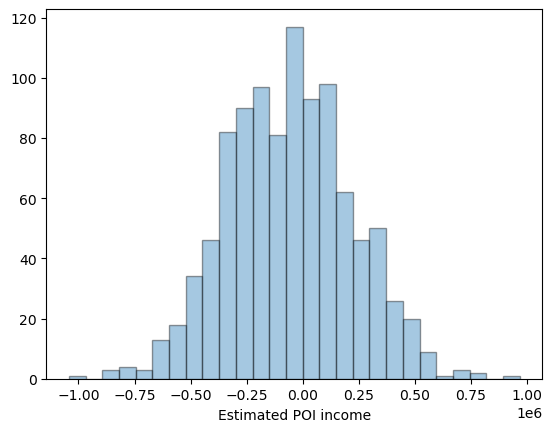

In [8]:
import warnings
import seaborn as sns

# hide warning created by outstanding scipy.stats issue
warnings.simplefilter(action='ignore', category=FutureWarning)

# distribution of POI income
ax = sns.distplot(poi_income_ests, kde = False, hist_kws = dict(edgecolor = 'black', linewidth = 1))
ax.set(xlabel = 'Estimated POI income');